<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/show_image_online_root.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code load ROOT, python 2 environment. Runs this part only the first time.

In [1]:
# sitallazione di ROOT dal CERN
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

# main paths for ROOT  
import sys
sys.path.append("/content/APPS/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf.so')
# itsllation and root-numpy main PATH
!pip install root-numpy
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMultiProc.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTreePlayer.so')
# patch to open online FILE
! sudo apt-get install libdavix0v5
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRDAVIX.so')
! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
! tail -1 $HOME/.rootrc

/content
--2020-11-13 10:18:32--  https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz
Resolving root.cern.ch (root.cern.ch)... 137.138.13.143, 2001:1458:201:45::100:b
Connecting to root.cern.ch (root.cern.ch)|137.138.13.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137415272 (131M) [application/x-gzip]
Saving to: ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’

root_v6.13.08.Linux 100%[===================>] 131.05M  16.4MB/s    in 8.9s    

2020-11-13 10:18:42 (14.8 MB/s) - ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’ saved [137415272/137415272]

     |████████████████████████████████| 522kB 9.6MB/s 
  Created wheel for root-numpy: filename=root_numpy-4.8.0-cp27-cp27mu-linux_x86_64.whl size=1075590 sha256=e810c3053de50aa615e540db6807d0b727225a713a1bd7dd3c6280f12114245f
  Stored in directory: /root/.cache/pip/wheels/f0/3c/18/62ccf3aec0284175916617d699f179d7cdbe4de0c7070be2a5
Successfully built root-numpy
Reading pack

Load the funcion to retrive data from swift CYGNO server

In [2]:
!pip install -q  python-swiftclient
!pip install -q  keystoneauth1
!pip install -q  h5py
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp
! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_resolution = y_resolution = 2048
cy.set_atlas_style('square')
!mkdir -p data

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 266kB 9.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
Welcome to JupyROOT 6.13/08
rm: cannot remove 'cygnus_lib.*': No such file or directory
rm: cannot remove 'mylib.*': No such file or directory
--2020-11-13 10:19:24--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35047 (34K) [text/plain]
Saving to: ‘cygnus_lib.py’

cygnus_lib.py       100%[===================>]  34.23K  --.-KB/s    in 0s      

2020-11-13 10:19:24 (74.4 MB/s) - ‘cygnus_lib.py’ saved [35047/35047]

--2020-11-13 10:19:24--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
Resolving raw.githubuse

download file [rum] from [tag] 

In [3]:
run = 2309
tag = "LAB" # Run tag: MAN, FNG, LAB, BTF, LTD
print ('Open file: '+cy.swift_root_file(tag, run))
f = ROOT.TFile.Open(cy.swift_root_file(tag, run))
# to download and open file
# f = cy.swift_read_root_file(cy.swift_root_file(tag, run))
# not useed anymore 
print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = cy.root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: %d " % (max_image))
print ("# of Waveform (TH2) Files: %d " % (max_wfm))

Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02309.root
Find Keys: 204
# of Images (TH2) Files: 102 
# of Waveform (TH2) Files: 102 


show imege file from [ini] to [end]

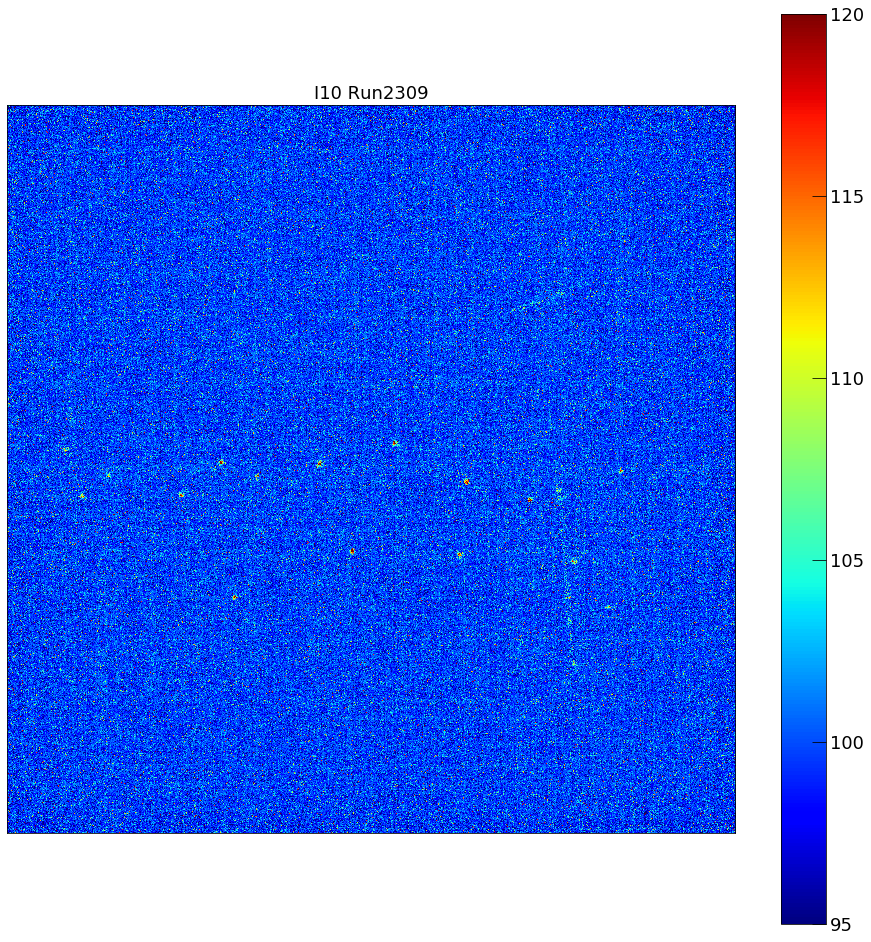

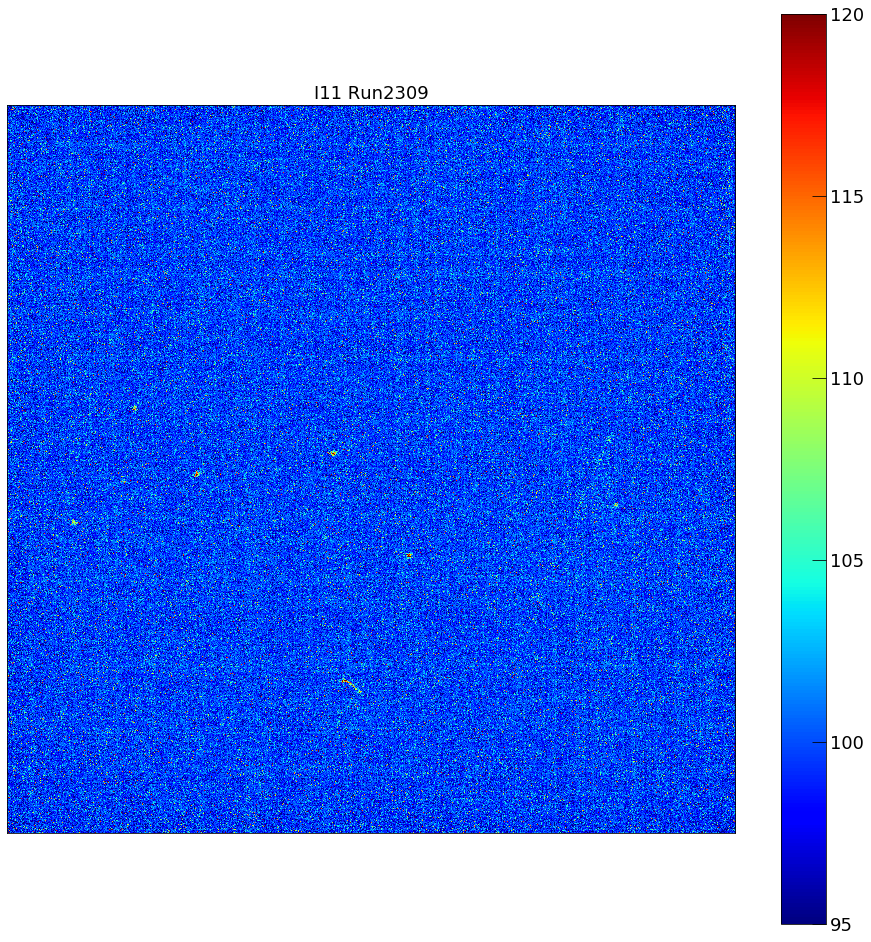

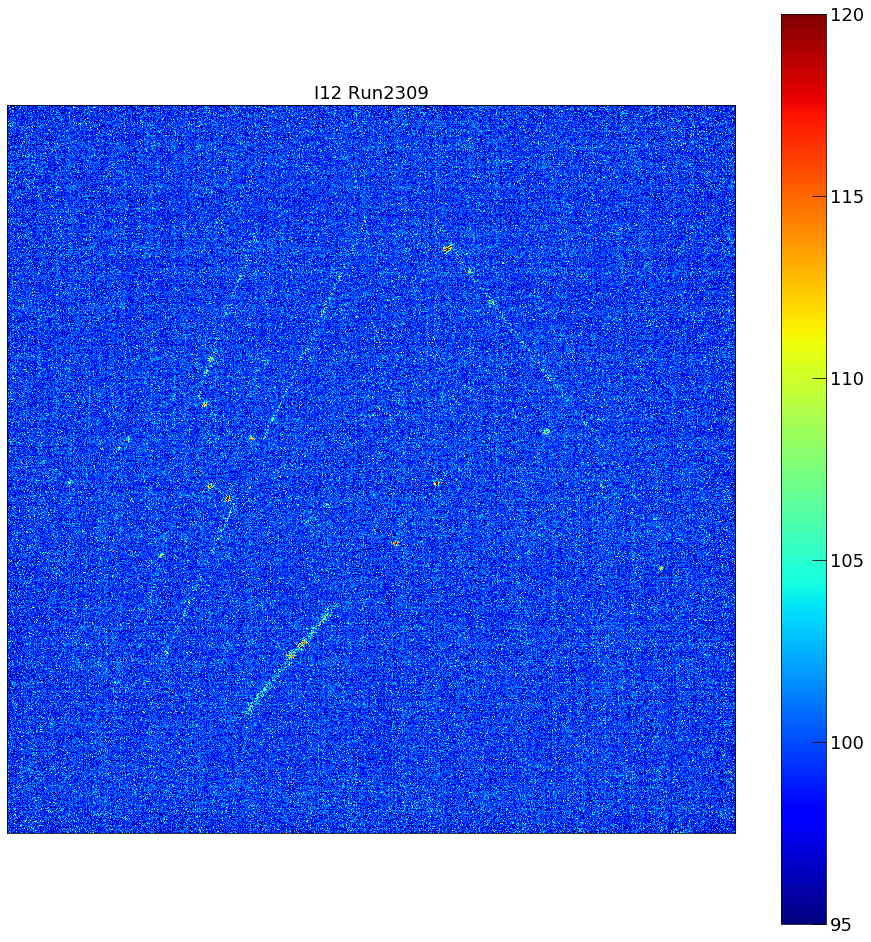

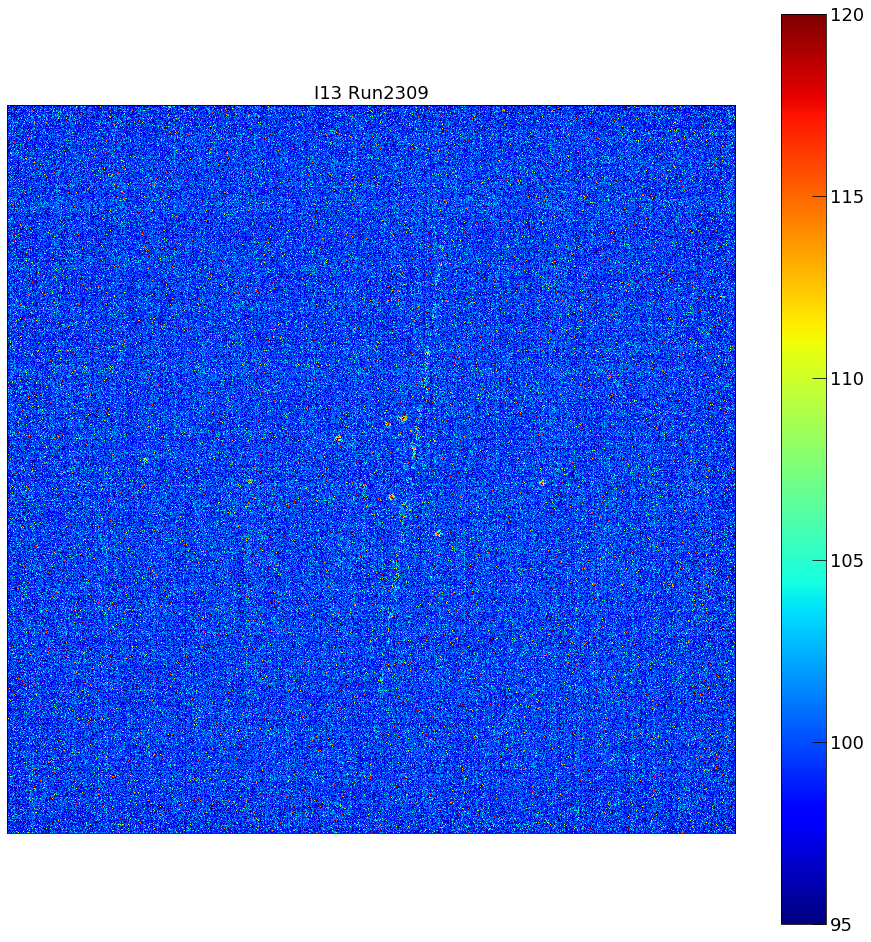

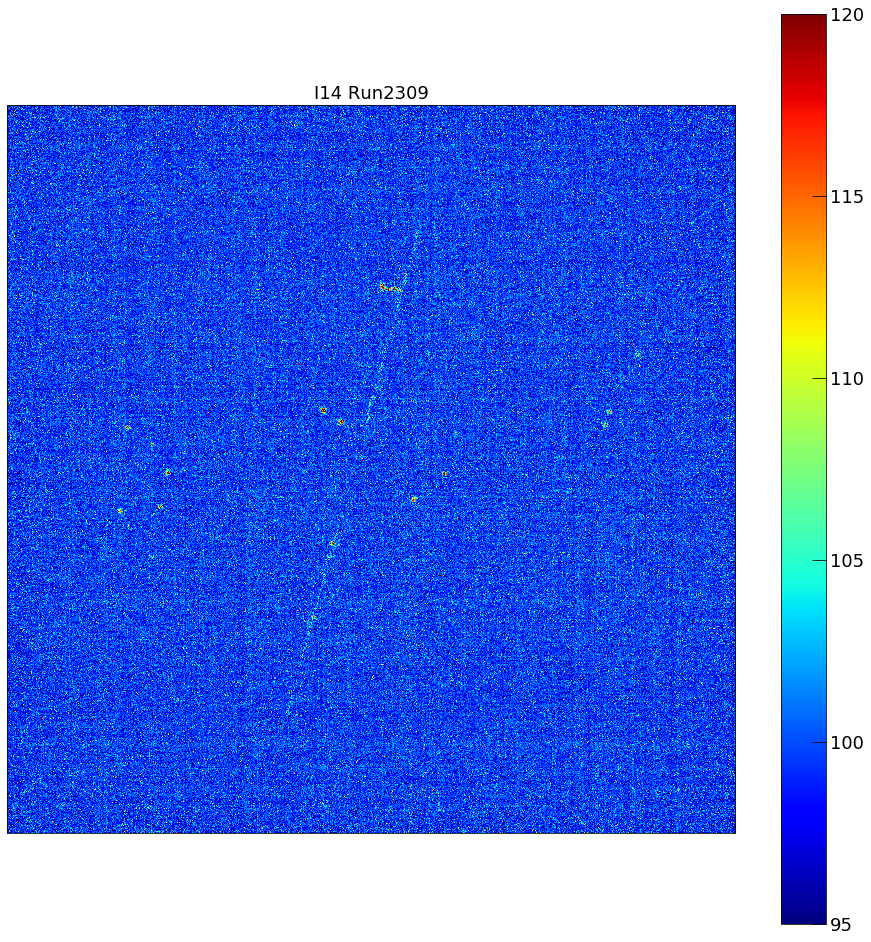

In [4]:
ini = 10
end = ini+5
save = 0
for iTr in range(ini,end):
    image = rtnp.hist2array(f.Get(pic[iTr])).T
    fig = plt.figure(figsize=(16,16))
    plt.title("I%d Run%d" % (iTr, int(run)))
    plt.imshow(image,  cmap="jet", vmin=95,vmax=120)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    if save == 1:
        plt.savefig('./images/I%dRun%s.png' % (iTr, run), format='png',  dpi = 400, bbox_inches = 'tight', pad_inches = 0)
    plt.show()

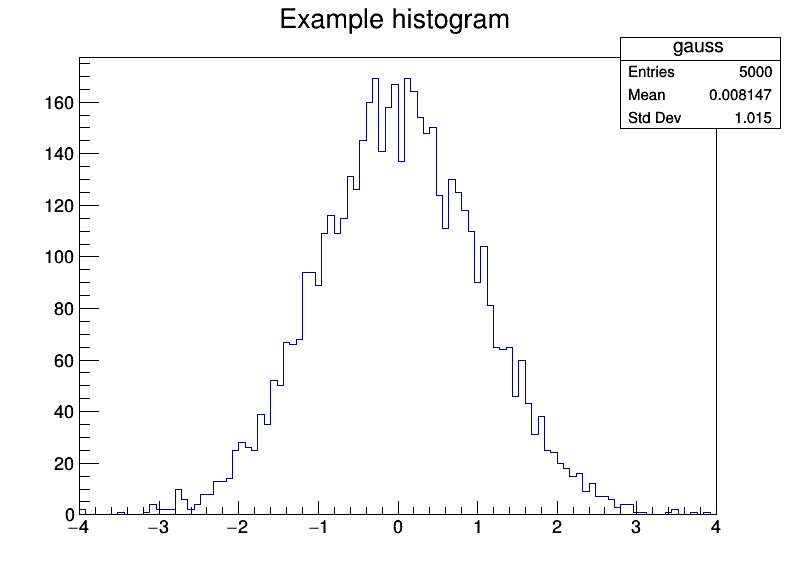

In [5]:
import ROOT
h = ROOT.TH1F("gauss","Example histogram",100,-4,4)
h.FillRandom("gaus")
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
h.Draw()
c.Draw()

In [6]:
image

array([[100., 104.,  97., ..., 101.,  98.,  99.],
       [101.,  96.,  99., ...,  97.,  97.,  96.],
       [100.,  98., 101., ..., 100.,  98., 100.],
       ...,
       [100.,  96.,  96., ...,  96.,  96.,  93.],
       [ 99.,  97.,  98., ...,  96., 106.,  98.],
       [100.,  98., 100., ..., 101., 100., 100.]], dtype=float32)

In [7]:
image_b = np.uint8(image)
image_b

array([[100, 104,  97, ..., 101,  98,  99],
       [101,  96,  99, ...,  97,  97,  96],
       [100,  98, 101, ..., 100,  98, 100],
       ...,
       [100,  96,  96, ...,  96,  96,  93],
       [ 99,  97,  98, ...,  96, 106,  98],
       [100,  98, 100, ..., 101, 100, 100]], dtype=uint8)

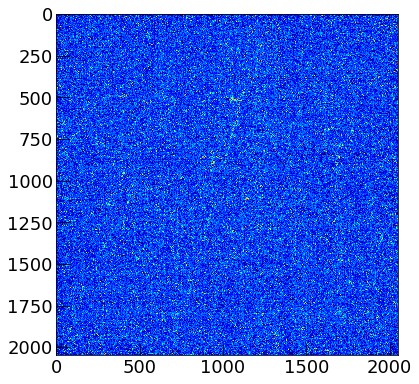

In [8]:
plt.imshow(image_b,  cmap="jet", vmin=95,vmax=120)

In [9]:
import struct
with file('float.bmt', 'wb') as f:
    f.write(image)
with file('byte.bmt', 'wb') as f:
    f.write(image_b)
with file('byteb.bmt', 'wb') as f:
    f.write(image_b.tobytes())


In [10]:
!ls -lh

total 25M
drwxr-xr-x 3 root root 4.0K Nov 13 10:18 APPS
-rw-r--r-- 1 root root 4.0M Nov 13 10:19 byteb.bmt
-rw-r--r-- 1 root root 4.0M Nov 13 10:19 byte.bmt
-rw-r--r-- 1 root root  35K Nov 13 10:19 cygnus_lib.py
-rw-r--r-- 1 root root  31K Nov 13 10:19 cygnus_lib.pyc
drwxr-xr-x 2 root root 4.0K Nov 13 10:19 data
-rw-r--r-- 1 root root  16M Nov 13 10:19 float.bmt
-rw-r--r-- 1 root root  18K Nov 13 10:19 mylib.py
-rw-r--r-- 1 root root  20K Nov 13 10:19 mylib.pyc
drwxr-xr-x 1 root root 4.0K Nov  6 17:30 sample_data


In [16]:
(1024*1024*2**8)/(1024*1024)

256

In [26]:
a = 10.2
type(a)

float

In [13]:
2**16/2**8

256

In [14]:
X = np.array([[1,2,3],[4,5,6]])
b = struct.pack('=%sf' % X.size, *X.flatten('F'))